In [2]:
# Kütüphaneler

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import mean_squared_error , r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale     # standardizasoyon işlemleri
from sklearn.preprocessing import StandardScaler    # standardizasoyon işlemleri
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from warnings import filterwarnings
filterwarnings("ignore")     # önceki bölümlerde çalıştırdığımızda çıkan gereksiz uyarı mesajları çıkmasın diye

In [3]:
df = pd.read_csv("C:\Makine Öğrenmesi-2\Hitters.csv")
df = df.dropna()

dms = pd.get_dummies(df[["League" , "Division" , "NewLeague"]])

y = df["Salary"]

x__ = df.drop(["Salary" , "League" , "Division" , "NewLeague"] , axis=1).astype("float64")
x = pd.concat([x__ , dms[["League_N" , "Division_W" , "NewLeague_N"]]] , axis=1)

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.25 , random_state=42)

# MODEL

In [4]:
gbm_model = GradientBoostingRegressor().fit(x_train , y_train)

# TAHMİN

In [5]:
# İlkel test hatamız
y_pred = gbm_model.predict(x_test)
np.sqrt(mean_squared_error(y_test , y_pred))

352.0841925902588

# MODEL TUNING (DOĞRULAMA)

***ÖNEMLİ PARAMETRELER:***

- criterion = 'friedman_mse'  -> bölünmelerle ilgili saflık ölçüsü
- learning_rate = 0.1 -> ağaçların katkısıyla ilgili göz önünde bulundurulan bir değer
- loss = 'loss' -> kayıp fonksiyonu bazen cost bazen loss olarak farklı farklı değerlendirilebilir. Buradaki 'ls' ifadesi en küçük kareleri ifade eder. Bu da gerçek değerler ile tahmini değerler arasındaki farklar yani artıklar
- subsample = 1.0 -> oluşturulacak olan ağaçları oluştururken göz önünde bulundurulacak olan ifade. 1 yazdığımızda hepsini dahil ederek ağaç oluşturmuş oluyor.


- ***robust parametre*** demek aykırı verilere karşı dayanıklı demektir. Bu da örneğin gerçek değer 1000 tahminimiz 9000. Bu büyük artığı duyarlıdır anlamına geliyor

In [6]:
?gbm_model

Type:        GradientBoostingRegressor
String form: GradientBoostingRegressor()
Length:      100
File:        c:\python312\lib\site-packages\sklearn\ensemble\_gb.py
Docstring:  
Gradient Boosting for regression.

This estimator builds an additive model in a forward stage-wise fashion; it
allows for the optimization of arbitrary differentiable loss functions. In
each stage a regression tree is fit on the negative gradient of the given
loss function.

:class:`sklearn.ensemble.HistGradientBoostingRegressor` is a much faster
variant of this algorithm for intermediate datasets (`n_samples >= 10_000`).

Read more in the :ref:`User Guide <gradient_boosting>`.

Parameters
----------
loss : {'squared_error', 'absolute_error', 'huber', 'quantile'},             default='squared_error'
    Loss function to be optimized. 'squared_error' refers to the squared
    error for regression. 'absolute_error' refers to the absolute error of
    regression and is a robust loss function. 'huber' is a
    comb

In [7]:
# Grid Search yapacağımız parametreleri verelim ve daha sonra en iyi sonucu hangi parametrelerle veriyor onu bulalım

gbm_params = {"learning_rate": [0.001 , 0.1 , 0.01] , "max_depth": [3,5,8] , "n_estimators": [100,200,500] , "subsample": [1,0.5,0.8] , "loss": ["ls" , "lad" , "quantile"]}

In [8]:
gbm_cv_model = GridSearchCV(gbm_model , gbm_params , cv=10 , n_jobs=-1 , verbose=2).fit(x_train , y_train)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


In [32]:
# En iyi hangi parametrelerle sonuç çıkıyormuş ona bakalım

gbm_cv_model.best_params_

{'learning_rate': 0.1,
 'loss': 'quantile',
 'max_depth': 8,
 'n_estimators': 500,
 'subsample': 0.5}

In [33]:
# En iyi çıktı veren parametreleri kullanarak final modelimizi oluşturalım

gbm_tuned = GradientBoostingRegressor(learning_rate=0.1 , loss="quantile" , max_depth=8 , n_estimators=500 , subsample=0.5).fit(x_train , y_train)

In [34]:
# Final modelimizle tahminde bulunarak hata oranımızı da bulalım

y_pred = gbm_tuned.predict(x_test)
np.sqrt(mean_squared_error(y_test , y_pred))


# Başlıngıçta 352 iken şu an 347'ye düştü

347.40403764883064

# DEĞİŞKENLERİN ÖNEM DÜZEYİ

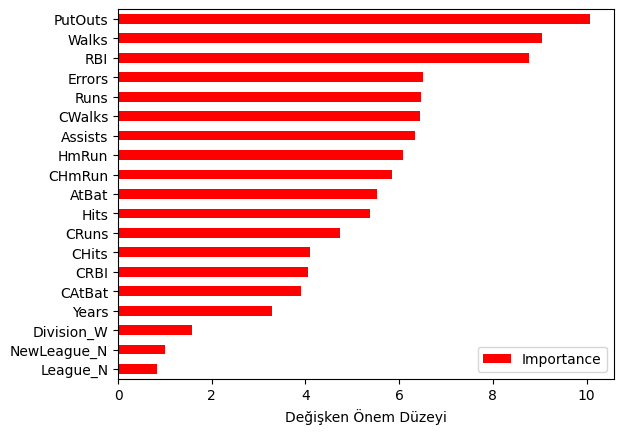

In [35]:
Importance = pd.DataFrame({"Importance": gbm_tuned.feature_importances_*100} , index= x_train.columns)
Importance.sort_values(by= "Importance" , axis=0 , ascending=True).plot(kind="barh" , color="r")

plt.xlabel("Değişken Önem Düzeyi")
plt.gca().legend = None